In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import scanpy as sc
import h5py

import sys

print(f'PID number is {os.getpid()}')

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

PID number is 26724


# Load adata

In [2]:
adata =sc.read_h5ad(r"MeCP2_clustered_adata_labeled.h5ad")

In [3]:
# load Mecp2 info
df_cell_with_MeCP2 = pd.read_csv(r'all_cells_info.csv', index_col=0)
uid_to_genotype = {uid:genotype for (uid,genotype) in zip(df_cell_with_MeCP2.uid, df_cell_with_MeCP2.genotype)}
adata.obs['cell_uid'] = adata.obs.index
adata.obs['genotype'] = adata.obs['cell_uid'].apply(lambda x: uid_to_genotype[x] if x in uid_to_genotype.keys() else 'ND')
adata.obs.drop(columns='cell_uid', inplace=True)
adata.obs

,fov,volume,center_x,center_y,min_x,max_x,min_y,max_y,experiment,mouse,age,n_genes_by_counts,total_counts,leiden,subclass_prediction_label,leiden_subclass_sub,subclass_manual_label,subclass_prediction_label_2,genotype
uid,,,,,,,,,,,,,,,,,,,
100488189023469889594930787401453076425,0,278.808456,-230.986007,-85.670002,-234.506807,-227.465207,-89.190802,-82.149202,0722,M1,2.5_month,45,139.0,1,Oligo,1,Oligo,Oligo,WT
112375315532908816646758313607652797643,0,327.773930,-352.270010,-115.694003,-356.546811,-347.993210,-119.862803,-111.525203,0722,M1,2.5_month,46,274.0,12,Oligo,12,OPC,Oligo,ND
114854375025109577381176113053841629115,0,441.613526,-395.794012,46.846002,-400.826812,-390.761211,42.785201,50.906802,0722,M1,2.5_month,64,216.0,1,Oligo,1,Oligo,Oligo,ND
118810555376811432243045980692848875157,0,237.102888,-327.538010,-47.330001,-331.058810,-324.017210,-50.742801,-43.917201,0722,M1,2.5_month,27,53.0,1,Oligo,1,Oligo,Oligo,KO
121417342135746412542665712718583471561,0,526.141489,-250.426008,-2.726000,-255.458808,-245.393208,-7.758800,2.306800,0722,M1,2.5_month,111,371.0,0,L6 CT,0,L6 CT,L6 CT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94651392123118829088321465793420452012,255,204.060174,1189.005992,127.702004,1185.269192,1192.742792,123.749204,131.654804,1107,Mc,6_month,85,213.0,9,L2/3 IT,9,L5 ET,L2/3 IT,KO
94750795428183338673959299756273926819,255,331.448090,1187.061992,141.418004,1182.893192,1191.230792,138.005204,144.830804,1107,Mc,6_month,36,164.0,4,Endo-PVM,4,Endo-PVM,Endo-PVM,KO
9632407225474561357286622891005710050,255,455.537194,1181.445992,24.670001,1176.197192,1186.694792,20.069201,29.270801,1107,Mc,6_month,125,457.0,0,L6 CT,0,L6 CT,L6 CT,WT


# Plot

In [4]:
mpl.rc('figure', dpi=300)
mpl.rc('figure', titlesize=10.) 
mpl.rc('figure.constrained_layout', use=True)

mpl.rc('axes', labelsize=8.)
mpl.rc('axes', titlesize=9.)
mpl.rc('axes', linewidth=0.5)

mpl.rc('font', family='Arial')

mpl.rc('savefig', dpi=300)
mpl.rc('savefig', format='pdf')

mpl.rc('xtick', labelsize=7.)
mpl.rc('xtick.major', size=3)
mpl.rc('xtick.major', width=1.)

mpl.rc('ytick', labelsize=7.)
mpl.rc('ytick.major', size=3)
mpl.rc('ytick.major', width=1.)

mpl.rcParams['pdf.fonttype'] = 42

figure_folder = r'results\cell_composition'

In [5]:
adata_plot = adata.copy()
adata_plot.obs['subclass'] = adata_plot.obs['subclass_manual_label']

def change_label(name):
    if name=='SMC-VLMC':
        return '  SMC-\nVLMC'
    elif name == 'Vip':
        return 'Vip    '
    elif name =='Sncg':
        return '   Sncg'
    elif name == 'Peri':
        return 'Peri  '
    elif name == 'other':
        return ''
    else:
        return name

adata_plot.obs['subclass'] = adata_plot.obs['subclass'].apply(lambda x: change_label(x))

C:\Users\cosmosyw\anaconda3\envs\merlin_postanalysis\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
meta NOT subset; don't know how to subset; dropped


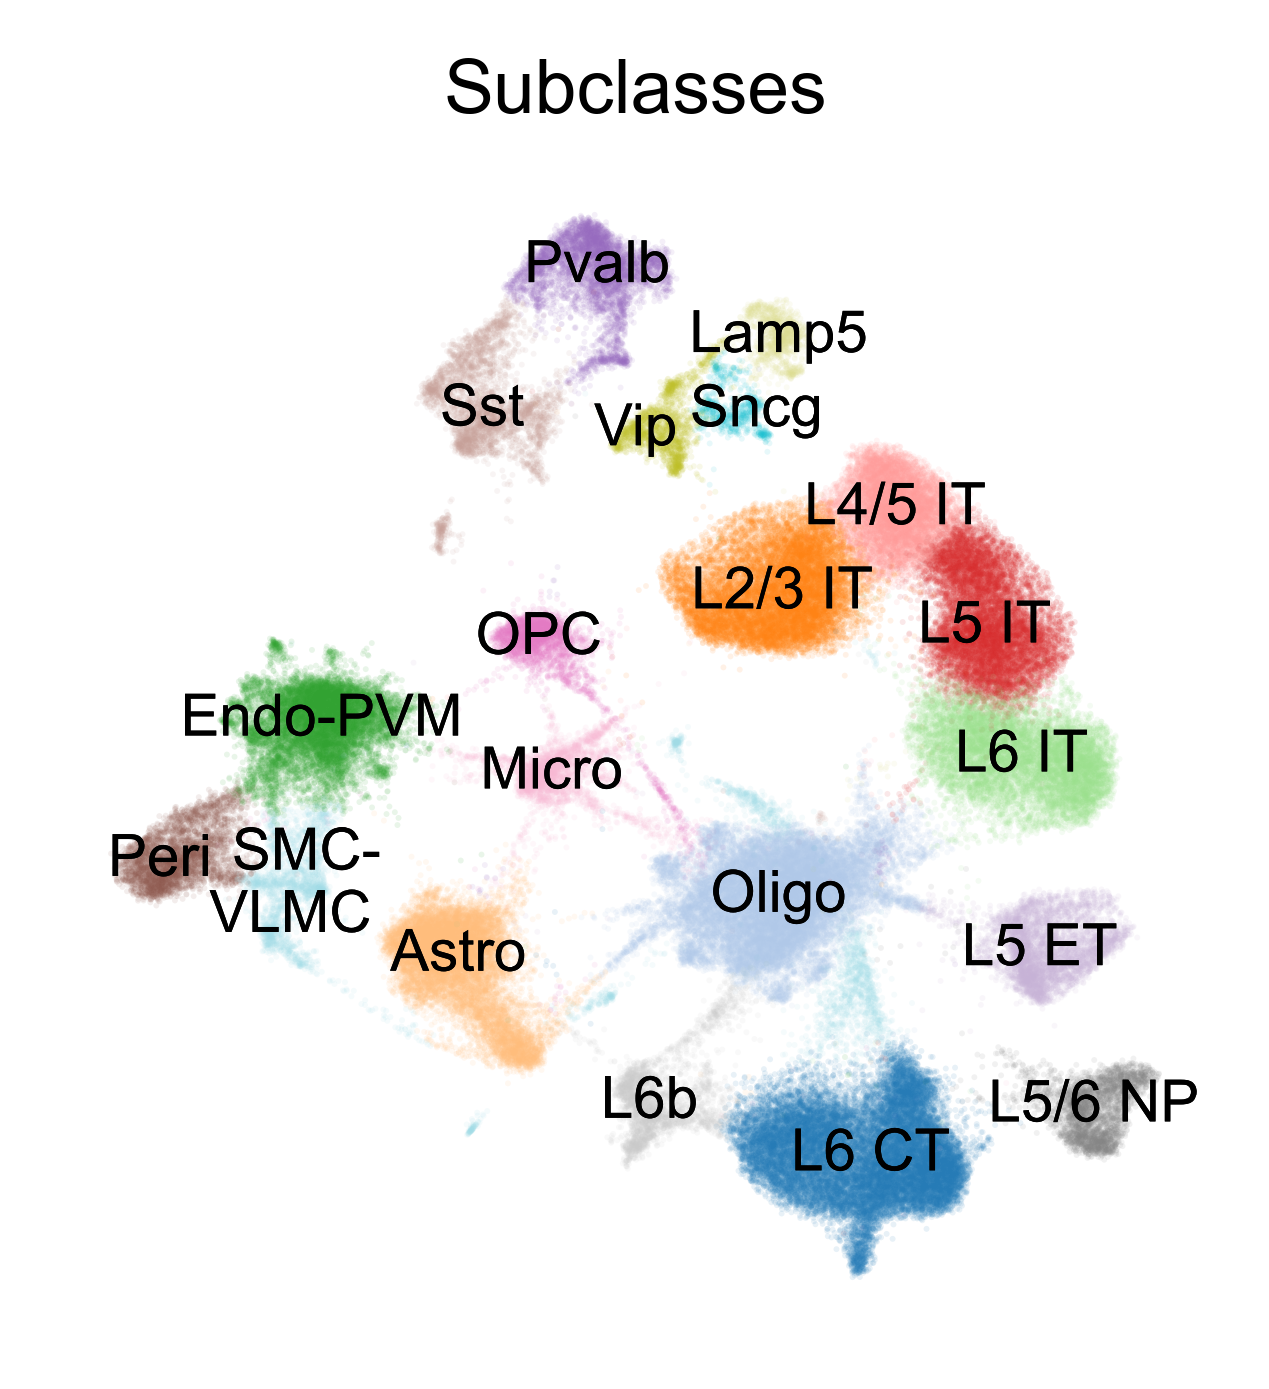

In [9]:
sc.set_figure_params(vector_friendly=True)

# Plot the manually labeled UMAP
fig = plt.figure(figsize=(2.0,2.2), dpi=300)

ax1 = fig.add_subplot(111)
ax1 = sc.pl.umap(adata_plot, color='subclass', 
                legend_loc='on data',legend_fontsize=7, legend_fontoutline=0, legend_fontweight='normal', 
           palette='tab20', ax=ax1, show=False, size=2, alpha=0.1)
ax1.axis('off')
ax1.set_title('Subclasses', fontsize=9)

figure_name = os.path.join(figure_folder, 'UMAP_subclass.svg')
plt.savefig(figure_name)
plt.savefig(figure_name.replace('svg', 'png'), transparent=True)
plt.savefig(figure_name.replace('svg', 'pdf'))
plt.show()

C:\Users\cosmosyw\anaconda3\envs\merlin_postanalysis\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
meta NOT subset; don't know how to subset; dropped


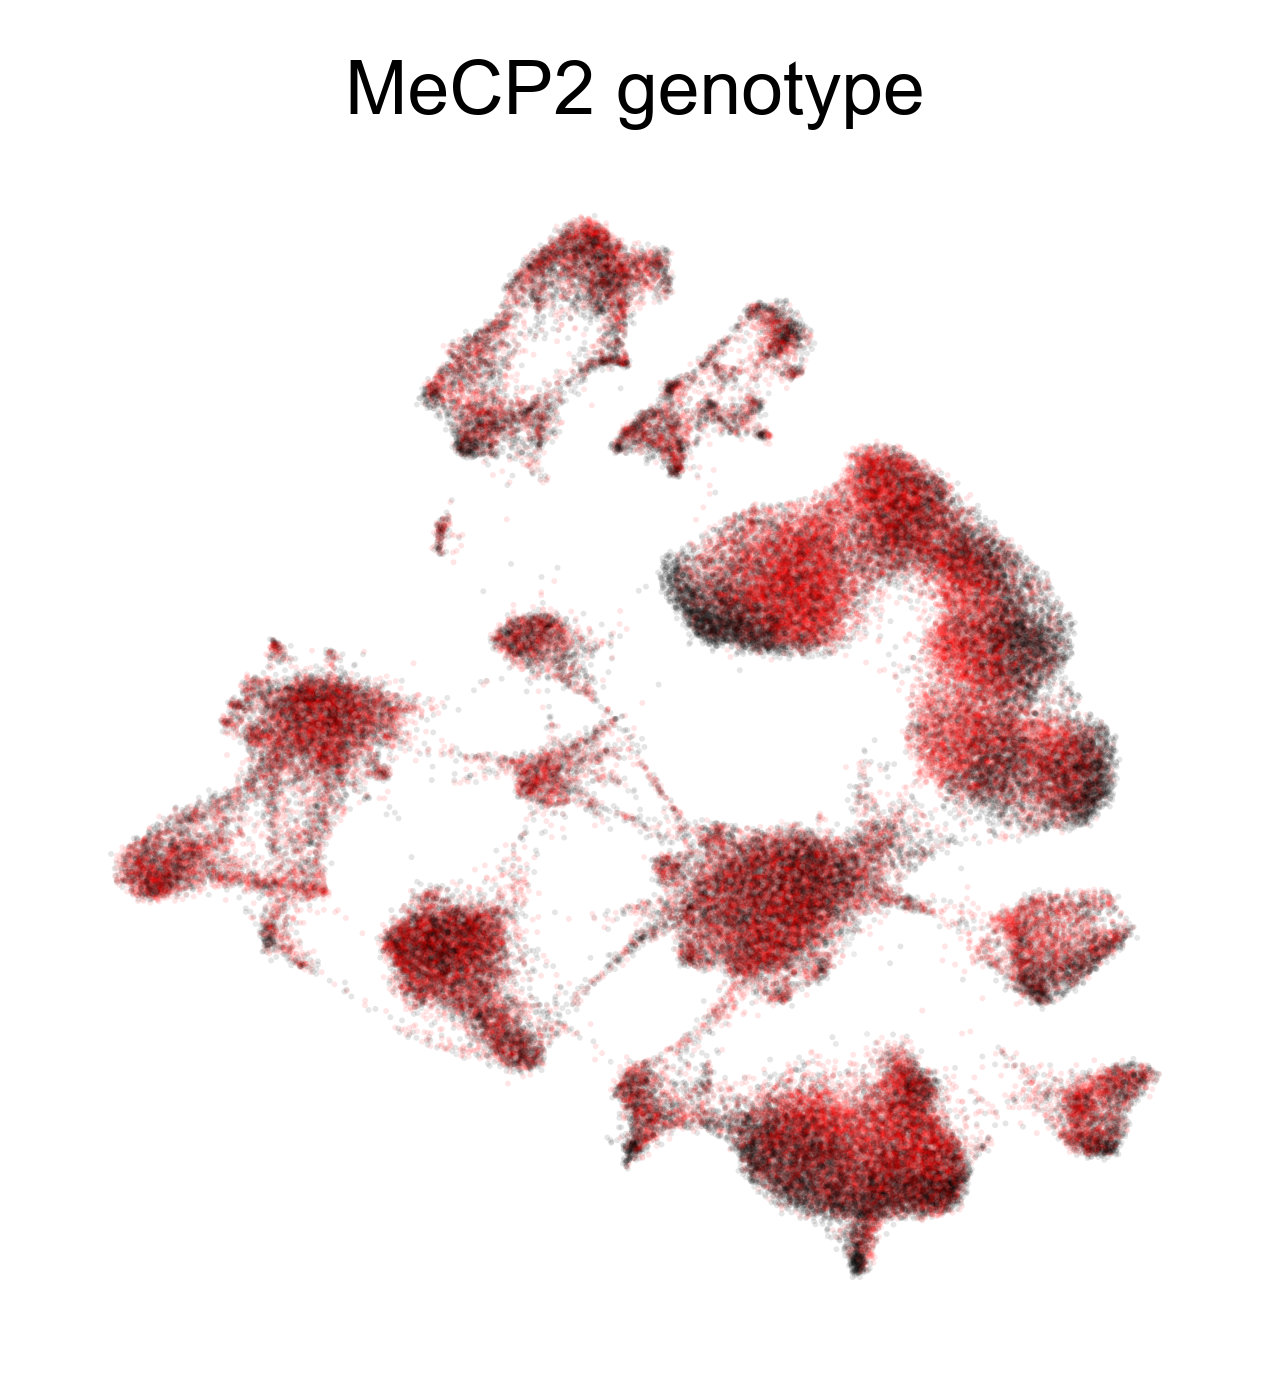

In [10]:
# Plot the manually labeled UMAP
fig = plt.figure(figsize=(2.,2.2), dpi=300)

ax2 = fig.add_subplot(111)
ax2 = sc.pl.umap(adata, color='genotype', palette={'WT':'black', 'KO':'red', 'ND':'white'}, ax=ax2, legend_loc='lower center',
                show=False, size=2, alpha=0.1)
ax2.axis('off')
ax2.set_title('MeCP2 genotype', fontsize=9)

figure_name = os.path.join(figure_folder, 'UMAP_genotype.svg')
plt.savefig(figure_name)
plt.savefig(figure_name.replace('svg', 'png'), transparent=True)
plt.savefig(figure_name.replace('svg', 'pdf'))
plt.show()